# Image Processing

In [1]:
import numpy as np
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
#from random import randrange
import cv2 
from torchsummary import summary #pip install torchsummary

### Image helper ###

In [2]:
def image_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2,1,0)))
    plt.show()
def get_image(i_dim, n_dim, n_pos, n_strength, pos_scale):
    image = torch.zeros((3, i_dim,i_dim), requires_grad=False)
    if isinstance(n_pos, torch.Tensor):
        #n_pos *= pos_scale
        i_n_pos = torch.clamp(torch.round(n_pos * pos_scale).type(torch.int), min=0, max=i_dim-n_dim)
    else:
        i_n_pos = np.round(n_pos * pos_scale).astype(int).clip(0,i_dim-n_dim)
    #print(i_n_pos)
    for c in range(3): #to get it equal over all chanels 
        image[c, i_n_pos[0].item():(i_n_pos[0].item() + n_dim),i_n_pos[1].item():(i_n_pos[1].item()+n_dim)] = n_strength
    return image
def net_show(input_label, n_pos, n_strength=torch.ones((3,3)), pos_scale=62):
    with torch.no_grad():
        for i in range(len(n_pos)):
            #get the guess
            npn_pos = n_pos[i].numpy()
            image = get_image(i_dim, n_dim, npn_pos, n_strength, pos_scale)
            image[1:3,:,:] = 0.0 #make the guess red
            #get the correct image
            label = input_label[i].numpy()
            npn_image = get_image(i_dim, n_dim, label, n_strength, pos_scale)
            #add them (clip) and show
            image = np.maximum(image, npn_image)
            image_show(image)
            #write information
            coord_l = np.round(label * pos_scale)
            coord_n = np.round(npn_pos * pos_scale)
            print(f"Loss: {loss_fn(input_label[i], n_pos[i])}, x_l = {coord_l[0]}, y_l = {coord_l[1]}, x_t = {coord_n[0]}, y_t = {coord_n[1]}.")

### Dataset helper

In [3]:
i_dim = 32
n_dim = 3
batch_size = 25
dataset_parameter = {
    "train": ("./pixel_finder_train_data.pth", 2000), 
    "test": ("./pixel_finder_test_data.pth", 500),
    "validate": ("./pixel_finder_validate_data.pth",500)}


In [4]:
class ImagePositionDataset(Dataset):
    def __init__(self, i_dim, n_dim, sample_size, path=""):
        self.i_dim = i_dim
        self.n_dim = n_dim
        self.pos_scale = i_dim-n_dim #changed from -1, because of rounding
        if path != "": #load the data
            self.load(path, i_dim, n_dim)
            assert sample_size == self.sample_size
        else: #create new data
            self.sample_size = sample_size
            self.data = []
            for i in range(sample_size):
                n_pos = torch.flatten(torch.rand((1,2)))
                n_strength = torch.rand((3,3))#np.random.rand(n_dim, n_dim) #one chanel
                n_pos *= self.pos_scale
                n_pos = torch.clamp(torch.round(n_pos),min=0,max=i_dim-n_dim)
                n_pos /= self.pos_scale
                self.data.append((n_pos, n_strength))
        
    def __len__(self):
        return self.sample_size
    
    def __getitem__(self, idx):
        sample = (get_image(i_dim, n_dim, self.data[idx][0], self.data[idx][1], self.pos_scale), self.data[idx][0], self.pos_scale)
        return sample
    
    def save(self, path):
        torch.save(self.data, path)
        
    def load(self, path, i_dim, n_dim):
        self.data = torch.load(path)
        self.sample_size = len(self.data)
        
        


### Create Dataset

In [14]:
#new dataset
dataset = {}
dataloader = {}
for name, parameter in dataset_parameter.items():
    dataset[name] = ImagePositionDataset(i_dim, n_dim, parameter[1])
    dataset[name].save(parameter[0])
    dataloader[name] = DataLoader(dataset[name], batch_size=batch_size,
                        shuffle=True, num_workers=0)


### Load Dataset

In [47]:
dataset = {}
dataloader = {}
for name, parameter in dataset_parameter.items():
    dataset[name] = ImagePositionDataset(i_dim, n_dim, parameter[1], path=parameter[0])
    dataloader[name] = DataLoader(dataset[name], batch_size=batch_size,
                        shuffle=True, num_workers=0)

### Test Dataset

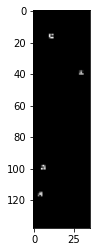

In [40]:
dataiter = iter(dataloader["train"])
images, labels, scales = dataiter.next()
image_show(torchvision.utils.make_grid(images))

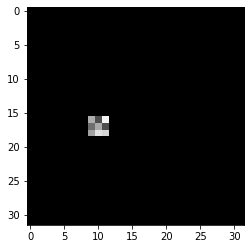

In [64]:
image,_,_ = dataset["validate"][0]
image_show(image)

### Test net on selected data

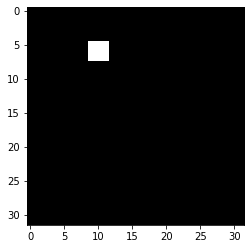

Loss: 2.1274898244882934e-05, x_l = 9.0, y_l = 5.0, x_t = 9.0, y_t = 5.0.


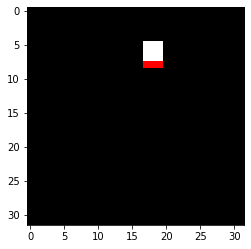

Loss: 0.00043316534720361233, x_l = 17.0, y_l = 5.0, x_t = 17.0, y_t = 6.0.


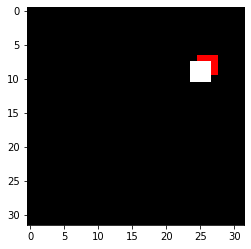

Loss: 0.0016078108455985785, x_l = 24.0, y_l = 8.0, x_t = 25.0, y_t = 7.0.


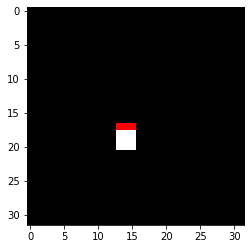

Loss: 0.0003879474534187466, x_l = 13.0, y_l = 18.0, x_t = 13.0, y_t = 17.0.


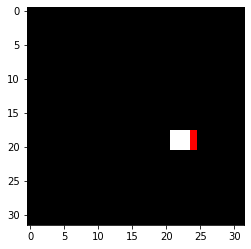

Loss: 0.0010472536087036133, x_l = 21.0, y_l = 18.0, x_t = 22.0, y_t = 18.0.


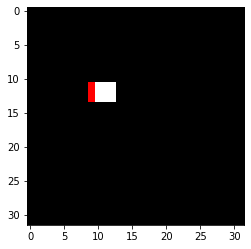

Loss: 0.001345467404462397, x_l = 10.0, y_l = 11.0, x_t = 9.0, y_t = 11.0.


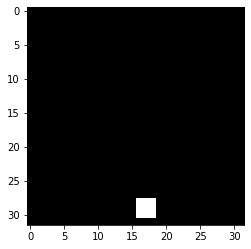

Loss: 6.72329479129985e-05, x_l = 16.0, y_l = 28.0, x_t = 16.0, y_t = 28.0.


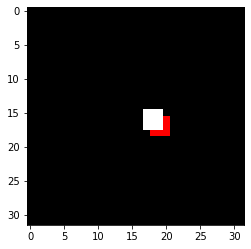

Loss: 0.0011336087482050061, x_l = 17.0, y_l = 15.0, x_t = 18.0, y_t = 16.0.


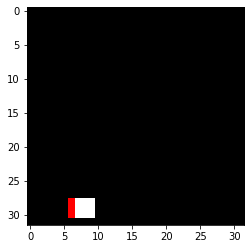

Loss: 0.001357757835648954, x_l = 7.0, y_l = 28.0, x_t = 6.0, y_t = 28.0.


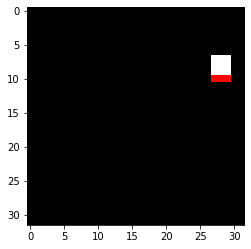

Loss: 0.0012721959501504898, x_l = 27.0, y_l = 7.0, x_t = 27.0, y_t = 8.0.


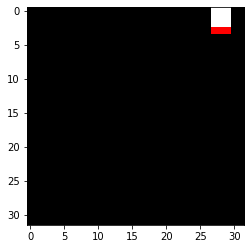

Loss: 0.0006049315561540425, x_l = 27.0, y_l = 0.0, x_t = 27.0, y_t = 1.0.


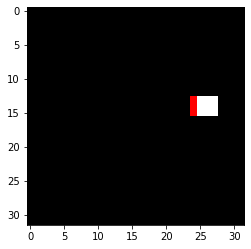

Loss: 0.0014368670526891947, x_l = 25.0, y_l = 13.0, x_t = 24.0, y_t = 13.0.


In [45]:
dataiter = iter(dataloader["validate"])
images, labels, scales = dataiter.next()
outputs = net[net_choice](images) 

net_show(labels, outputs,pos_scale=i_dim-n_dim)

In [74]:
outputs *(i_dim - n_dim)

tensor([[25.5487,  6.3102],
        [10.4187,  9.8633],
        [14.0806, 12.9848],
        [ 2.1276, 25.3744]], grad_fn=<MulBackward0>)

In [16]:
labels *(i_dim - n_dim)

tensor([[17., 23.],
        [13., 24.],
        [26., 21.],
        [ 4., 19.]])

In [73]:
for i in range(len(outputs)):
    print(loss_fn(outputs[i], labels[i]).item())

0.005425386596471071
0.00017682100587990135
0.0004358791629783809
0.0004538971115835011


In [ ]:
image_show(torchvision.utils.make_grid(images))

In [106]:
labels[0]

tensor([0.9438, 0.6781])

## Create the net

In [6]:
net_path = {}
net = {}

### Net helper

In [7]:
def getNetPath(net_choice, epoch, learnrate, original=False):
    if original:
        return f"{net_path[net_choice]}.pth"
    return f"{net_path[net_choice]}_lr_{learnrate}_ep_{epoch}.pth" 

### Convolution ####

In [ ]:
net_path["conv"] = './pixel_finder_conv'

In [ ]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels
    
    
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))



class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = ResNetLayer(3, 16, block=ResNetBasicBlock, n=2)
        self.fc1 = nn.Linear(32*32*16 , 1024)
        self.fc2 = nn.Linear(1024,2)
        self.sig = nn.Sigmoid()
        self.drop_out = nn.Dropout(p=0.2)


    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.sig(out)
        
        return out


net["conv"] = Net()

### Linear ###

In [12]:
net_path["linear"] = './pixel_finder_linear'

In [13]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(i_dim*i_dim*3, i_dim*i_dim*3)
        self.fc2 = nn.Linear(i_dim*i_dim*3,2)
        #self.drop_out = nn.Dropout(p=0.2)


    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


net["linear"] = LinearNet()

### Linear Sigmoid 

In [8]:
net_path["linearSig"] = './pixel_finder_linear_sig'

In [9]:
class LinearSigNet(nn.Module):
    def __init__(self):
        super(LinearSigNet, self).__init__()
        self.fc1 = nn.Linear(i_dim*i_dim*3, i_dim*i_dim*3)
        self.fc2 = nn.Linear(i_dim*i_dim*3,2)
        #self.drop_out = nn.Dropout(p=0.2)


    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)


net["linearSig"] = LinearSigNet()

### Select the net

In [21]:
net_choice = "linearSig"

## Train the net

In [10]:
hyperparameter = {
    "learnrate" : (0.0001, 0.00001),
    "epoch" : (4,)}


#### Individual tweaks

In [42]:
#Hyperparameter
learnrate = 0.00001
epoch = 2
hyperparameter = {
    "learnrate" : (learnrate,),
    "epoch" : (epoch,)}

net_choice = "linearSig"
optimizer[learnrate] = torch.optim.Adam(net[net_choice].parameters(), lr=learnrate)

### Loss, optimization criterion, optimization algorithm

In [14]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = {}
metrics = {}
for lr in hyperparameter["learnrate"]:
    optimizer[lr] = torch.optim.Adam(net[net_choice].parameters(), lr=lr)

In [86]:
def score(dataset_name):
    net[net_choice].eval()
    bias = 0.0
    with torch.no_grad():
        n_total = 0
        for i_batch, sample_batched in enumerate(dataloader[dataset_name]):
            inputs, labels, _ = sample_batched

            #calculate the output and loss
            outputs = net[net_choice](inputs)
            loss = loss_fn(outputs, labels)

            #track loss
            #loss_running += loss.item()
            bias += loss.item()
            n_total += 1
            #if i_batch % running_loss_count == running_loss_count -1:
                #print(f"(Batch {i_batch + 1}): {loss_running/running_loss_count}")
                #metrics[(num_epoch, learnrate, f"{dataset}_loss")].append(loss_running)
                #loss_running = 0.0
        bias /= (n_total * batch_size)
        return bias
    
def binomialScore(dataset_name, normed=True):
    net[net_choice].eval()
    categories = {}
    with torch.no_grad():
        for image, label, scale in dataset[dataset_name]:
            output = net[net_choice](image.unsqueeze(0)).flatten()
            pos_l = np.round(label * scale).type(torch.int)
            pos_n = np.round(output * scale).type(torch.int)
            delta = torch.sum(torch.abs(pos_l - pos_n)).item()
            if delta in categories.keys():
                categories[delta] += 1
            else:
                categories[delta] = 1
        if normed:
            for key in categories.keys():
                categories[key] /= len(dataset[dataset_name])
        return categories

In [75]:
binomialScore("test")

{4: 15, 0: 162, 2: 120, 1: 160, 3: 38, 7: 2, 5: 2, 6: 1}

### Trainingsloop

In [48]:
#output ten times
running_loss_count =  int(len(dataset["train"]) / (10 * batch_size)) 

In [49]:
# save starting net
torch.save(net[net_choice].state_dict(), getNetPath(net_choice, 0,0, original=True))

for num_epoch in hyperparameter["epoch"]:
    for learnrate in hyperparameter["learnrate"]:
        #load the original net to start from the same parameters
        net[net_choice].load_state_dict(torch.load(getNetPath(net_choice, 0,0, original=True)))
        net[net_choice].train()
        print(f"Calculate the net with {num_epoch} epochs and a learning rate of {learnrate}")
        for epoch in range(num_epoch):
            loss_running = 0.0
            metrics[(epoch + current_epoch, learnrate, "running_loss")] = []
            metrics[(epoch + current_epoch, learnrate, "validation_loss")] = []
            for i_batch, sample_batched in enumerate(dataloader["train"]):
                inputs, labels, _ = sample_batched
                
                #reset calculated gradients
                optimizer[learnrate].zero_grad()
                
                #calculate the output and loss
                outputs = net[net_choice](inputs)
                loss = loss_fn(outputs, labels)
                
                #backpropagate loss and optimize parameter
                loss.backward()
                optimizer[learnrate].step()
                
                #track loss
                loss_running += loss.item()
                if i_batch % running_loss_count == running_loss_count -1:
                    print(f"(Epoch {epoch + 1 + current_epoch}, batch {i_batch + 1}, {i_batch * batch_size}/{len(dataset['train'])}: {loss_running/(batch_size*running_loss_count)}")
                    metrics[(epoch + current_epoch, learnrate, "running_loss")].append(loss_running/(batch_size*running_loss_count))
                    loss_running = 0.0
            #save the trained net after each epoch
            torch.save({"net_state_dict":net[net_choice].state_dict(),
                   "optimizer_state_dict":optimizer[learnrate].state_dict(),
                   "epoch" : epoch,
                    "metrics" : metrics}, getNetPath(net_choice, epoch + current_epoch,learnrate))
            #save also the validation score after each epoch
            validation = score("validate")
            metrics[(epoch + current_epoch, learnrate, "validation_loss")].append(validation)
            print(f"Validation score: {validation}")
        current_epoch += num_epoch
print('Finished Training')

Calculate the net with 2 epochs and a learning rate of 1e-05


D:\Programme\Anaconda\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


(Epoch 2, batch 8, 175/2000: 0.0002869400195777416
(Epoch 2, batch 16, 375/2000: 0.0003260392416268587
(Epoch 2, batch 24, 575/2000: 0.00032970433356240393
(Epoch 2, batch 32, 775/2000: 0.0002765155164524913
(Epoch 2, batch 40, 975/2000: 0.00029745625448413193
(Epoch 2, batch 48, 1175/2000: 0.0003329000365920365
(Epoch 2, batch 56, 1375/2000: 0.0002393505279906094
(Epoch 2, batch 64, 1575/2000: 0.00034661372425034645
(Epoch 2, batch 72, 1775/2000: 0.00023652991629205644
(Epoch 2, batch 80, 1975/2000: 0.00035037171095609666
Validation score: 0.00174086157605052
(Epoch 3, batch 8, 175/2000: 0.0002582090860232711
(Epoch 3, batch 16, 375/2000: 0.00028090662672184406
(Epoch 3, batch 24, 575/2000: 0.0002395750256255269
(Epoch 3, batch 32, 775/2000: 0.0002988600730895996
(Epoch 3, batch 40, 975/2000: 0.00026450160657987
(Epoch 3, batch 48, 1175/2000: 0.0003802917758002877
(Epoch 3, batch 56, 1375/2000: 0.000283859051996842
(Epoch 3, batch 64, 1575/2000: 0.00026973261730745435
(Epoch 3, batch 

In [27]:
#Save the net as basis for the next round
torch.save(net[net_choice].state_dict(), getNetPath(net_choice, 0,0, original=True))

## Load a net

In [17]:
#Hyperparameter
learnrate = 0.00001
epoch = 1
hyperparameter = {
    "learnrate" : (learnrate,),
    "epoch" : (epoch,)}

net_choice = "linearSig"

In [18]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = {}
#print(getNetPath(net_choice, epoch, learnrate))
checkpoint = torch.load(getNetPath(net_choice, epoch, learnrate))
if "metrics" in checkpoint.keys(): 
    metrics = checkpoint["metrics"]
else:
    metrics = {}
    print("No metric found")
current_epoch = epoch
optimizer[learnrate] = torch.optim.Adam(net[net_choice].parameters(), lr=learnrate)
optimizer[learnrate].load_state_dict(checkpoint["optimizer_state_dict"])
net[net_choice].load_state_dict(checkpoint["net_state_dict"])


<All keys matched successfully>

In [53]:
#Reset to state before training
net[net_choice].load_state_dict(torch.load(getNetPath(net_choice, 0,0,original=True)))
current_epoch = 0

<All keys matched successfully>

## Net properties

In [26]:
summary(net[net_choice], input_size=(4,32,32))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x4096 and 3072x3072)

In [27]:
net[net_choice]

LinearSigNet(
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=2, bias=True)
)

## Metriken

In [ ]:
import matplotlib.pyplot as plt

### Bias 

In [29]:
#Linear net
train_score = score("train")
validation_score = score("validate")
test_score = score("test")
print(f"Training: {train_score}, Validation: {validation_score}, Test: {test_score}")

Training: 0.0007012143000938522, Validation: 0.02302990819979459, Test: 0.020292832299135626


In [37]:
#LinearSig net
train_score = score("train")
validation_score = score("validate")
test_score = score("test")
print(f"Training: {train_score}, Validation: {validation_score}, Test: {test_score}")

Training: 0.0014718312549248367, Validation: 0.0071511474107392135, Test: 0.007650388136971742


In [25]:
#LinearSig net Big Batch
train_score = score("train")
validation_score = score("validate")
test_score = score("test")
print(f"Training: {train_score}, Validation: {validation_score}, Test: {test_score}")

Training: 0.00028738852276001124, Validation: 0.0017345703765749931, Test: 0.001850445531308651


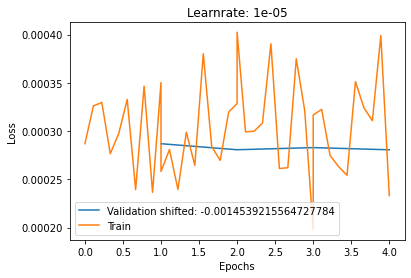

In [51]:
x_validation = []
y_validation = []
x_train = []
y_train = []
for epoch, learnrate, mode in metrics.keys():
    if mode == "validation_loss":
        x_validation.append(epoch)
        y_validation.extend(metrics[(epoch, learnrate, mode)])
    if mode == "running_loss":
        x_train.extend([i / 9 + (epoch-1) for i in range(10)])
        y_train.extend(metrics[(epoch, learnrate, mode)])
y_train = np.array(y_train)
y_validation = np.array(y_validation)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Learnrate: {learnrate}")
plt.plot(x_validation, (y_validation - y_validation[0] + y_train[0]),label=f"Validation shifted: {y_train[0] - y_validation[0]}")
plt.plot(x_train, y_train, label=f"Train")
plt.legend(loc='best')
plt.show()

In [50]:
metrics

{(1, 1e-05, 'running_loss'): [0.0002869400195777416,
  0.0003260392416268587,
  0.00032970433356240393,
  0.0002765155164524913,
  0.00029745625448413193,
  0.0003329000365920365,
  0.0002393505279906094,
  0.00034661372425034645,
  0.00023652991629205644,
  0.00035037171095609666],
 (1, 1e-05, 'validation_loss'): [0.00174086157605052],
 (2, 1e-05, 'running_loss'): [0.0002582090860232711,
  0.00028090662672184406,
  0.0002395750256255269,
  0.0002988600730895996,
  0.00026450160657987,
  0.0003802917758002877,
  0.000283859051996842,
  0.00026973261730745435,
  0.00031970170326530936,
  0.00032864104956388475],
 (2, 1e-05, 'validation_loss'): [0.0017346212342381478],
 (3, 1e-05, 'running_loss'): [0.00040248190402053296,
  0.0002993106539361179,
  0.0002998688747175038,
  0.0003083291184157133,
  0.000390523080714047,
  0.00026123977964743973,
  0.00026204619207419454,
  0.00037500335136428473,
  0.0003211103705689311,
  0.00019758756854571403],
 (3, 1e-05, 'validation_loss'): [0.001736

### Distance

In [89]:
distance_test = binomialScore("test")
distance_train = binomialScore("train")
distance_validation = binomialScore("validate")

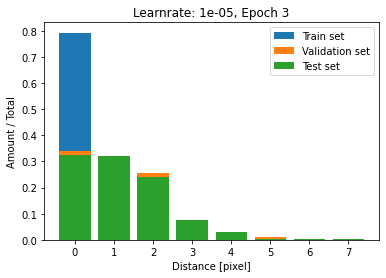

In [93]:
plt.xlabel("Distance [pixel]")
plt.ylabel("Amount / Total")
plt.title(f"Learnrate: {learnrate}, Epoch {current_epoch}")
plt.bar(list(distance_train.keys()), list(distance_train.values()),label=f"Train set")
plt.bar(list(distance_validation.keys()), list(distance_validation.values()),label=f"Validation set")
plt.bar(list(distance_test.keys()), list(distance_test.values()),label=f"Test set")
plt.legend(loc='best')
plt.show()